In [1]:
import cv2
import os
import pandas as pd

import torch
from torch import nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets 

from torchmetrics.classification import BinaryAccuracy
from torchmetrics import ConfusionMatrix

import copy
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

from efficientnet_pytorch import EfficientNet

In [2]:
# There are issues with using a subset, therefore subsets must be converted back into a dataset
def convert_subset_to_imagefolder(subset, root, transform=None):
    dataset = datasets.ImageFolder(root, transform)
    dataset.samples = [subset.dataset.samples[i] for i in subset.indices]
    return dataset

# This code was copied from online since Pytorch does not have a built in Early stopping system
class EarlyStopping():
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""
    
    def __call__(self, model, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model)
            
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model.load_state_dict(model.state_dict())
            
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            
        if self.counter >= self.patience:
            self.status = f"Stopped on {self.counter}"
            
            if self.restore_best_weights:
                model.load_state_dict(self.best_model.state_dict())
            return True
        
        self.status = f"{self.counter}/{self.patience}"
        return False

In [3]:
# Custom Dataset class
class CustomDataset(Dataset):
    
    # Init has to find all paths to image and labels
    def __init__(self, root_dir, generator=None, transform=None, normalize=True):

        self.root_dir = root_dir
        self.transform = transform
        self.generator = generator
        self.normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) \
        if normalize else nn.Identity()
        
        # Classifications of the objects
        self.definitions = os.listdir(self.root_dir)
        
        data = []
        # Go through each defination and add each image path to the csv
        for label in self.definitions:
            label_path = self.root_dir + label + "/"
            
            for image in os.listdir(label_path):
                
                # Check if file is of an image type
                if image.split('.')[-1] not in ["png", "jpg", "jpeg"]:
                    continue
                
                # If it is, then append the path to the image as well as the label given by the folder
                data.append({
                    'path': label_path + image,
                    'label': self.definitions.index(label)
                })
        
        # Save to a dataframe
        self.csv = pd.DataFrame(data)

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        
        # Extract the path and label of a datapoint
        img_path = self.csv.iloc[idx]['path']
        label = self.csv.iloc[idx]['label']
        
        # Open the image and ensure 3 channels
        img = Image.open(img_path)
        img = img.convert('RGB')

        # if there is a transformation, apply it
        if self.transform:
            img = self.transform(img)
        
        # If generator to upscale image
        if self.generator:
            with torch.no_grad():
                img = self.generator(img.reshape(1,3,32,32).to(config.device))
                img = img.to("cpu")
                img = img[0]
                
        img = self.normalize(img)

        return (img, label)

### Set the hyperparameters of your model. 10 pt
Max epochs was selected to be 25 in order to allow the model to begin overfitting to the data and making the Earlystop functionality kick in before model was too far. This coincides with the learning rate selected: 0.0001. Higher rates were previously trained, however the smoothest results were shown with this learning rate. Batch size of 64 was selected to reach the near the peak of my system pocessing a 3080 10gb, also because 64 is a fun number due to it being a power of 2. Image size was determined by the github repository of EfficientNet. Adam Optimizer was selected later on due to its prevalence in the machine learning world.  


In [4]:
# A class build to hold all configurations to train the model
class Configuration:
    def __init__(self, basePath, modelName, EPOCHS, LR, batchSize, imgSize):
        self.trainPath = basePath + "train/"
        self.testPath = basePath + "test/"
        
        self.EPOCHS = EPOCHS
        self.lr = LR
        self.bs = batchSize
        self.Is = (imgSize, imgSize)
        self.train_validate_percent = 0.95
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.modelName = modelName

config = Configuration(basePath="../datasets/Retinal_OCT/", modelName="efficientnet-b0", EPOCHS=25, LR=0.0001, batchSize=64, imgSize=32)

In [5]:
# Using transforms to augment data by randomizing in multiple ways, rotation, translation, and scaling
train_transform = transforms.Compose([
                                        transforms.Resize(size=config.Is),
                                        transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                        transforms.ToTensor(),
                                        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# Test and Validation transformations did not have the same modifications
test_transform = transforms.Compose([
                                        transforms.Resize(size=(128,128)),
                                        transforms.ToTensor(),
                                        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

In [6]:
#Load generator
from utils.Models import SR_Generator
Generator = SR_Generator( body_arch= [(5,64)]).to(config.device)
test_input = torch.rand(1,3,32,32).to(config.device)
_=Generator(test_input)
Generator.load_state_dict(torch.load("models/generator_model_285.pth"))

Generator.eval()

train = CustomDataset(config.trainPath)

# Splits training dataset into training and validation sets
validNum = int(len(train) * config.train_validate_percent)
train, validate = random_split(train, [validNum, len(train) - validNum])

v = copy.deepcopy(validate)
del validate
validate = v

train.dataset.transform = train_transform
validate.dataset.transform = test_transform
train.dataset.generator = Generator


# Creates the initial ImageFolder dataset from the testing path
test = CustomDataset(config.testPath, transform=test_transform)

# Prints infomation about the datasets
print("\nTraining Dataset\n", len(train))
print("\nValidation Dataset\n", len(validate))
print("\nTesting Dataset\n", len(test))

C:\Users\gmald\anaconda3\envs\genml\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '



Training Dataset
 18156

Validation Dataset
 956

Testing Dataset
 930


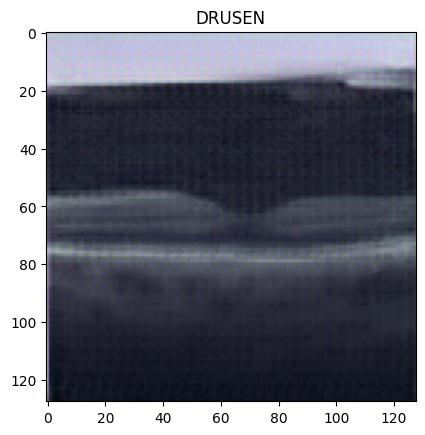

In [7]:
# Precalculated the number each class to ensure a balanced dataset
classTrainCount = {"DME":10847, "DRUSEN":8265} 

# Sets string definitions based on integer values
definitions = {0:"DME", 1:"DRUSEN"}

img, label = train[5]
img = torch.permute(img, (1,2,0))

# View some of the training Data
img = (img-torch.min(img)) / (torch.max(img)-torch.min(img))
plt.imshow(img)
_=plt.title(definitions[label])

In [8]:
# Create all three dataloaders for the training, validating, and testing datasets
trainLoader = DataLoader(train, batch_size=config.bs, shuffle=True, num_workers=0)
validationLoader = DataLoader(validate, batch_size=config.bs, shuffle=True, num_workers=0)
testLoader = DataLoader(test, batch_size=config.bs, shuffle=True, num_workers=0)

In [9]:
testLoader.dataset.generator

In [10]:
# Loads model from the EfficientNet library (pretrained)
model = EfficientNet.from_pretrained(config.modelName)

# Prints the inital fully connected classification layer
print(model._fc, "\n")

# Creates new sequential fully connected classification layers 
model._fc = nn.Sequential(
    nn.Linear(in_features= model._fc.in_features, out_features= 512),
    nn.ReLU(),
    nn.Linear(in_features= 512, out_features= 128),
    nn.ReLU(),
    nn.Linear(in_features= 128, out_features= 2),
    nn.Sigmoid(),
)

# Prints new layer
print(model._fc)

Loaded pretrained weights for efficientnet-b0
Linear(in_features=1280, out_features=1000, bias=True) 

Sequential(
  (0): Linear(in_features=1280, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=2, bias=True)
  (5): Sigmoid()
)


In [11]:
# Creates a large trainer class for training and saving metrics of our model
class ModelTrainer:
    
    def __init__(self, model, loss, optimizer):
        
        # Sets model to GPU and basic loss function and optimizer used
        self.model = model.to(config.device)
        self.Loss_Function = loss
        self.optimizer = optimizer
        
        # Place to store metrics of our model throughout training and testing
        self.Metrics = {"Training Loss":[], "Validation Loss":[], 
                        "Training Accuracy":[], "Validation Accuracy":[],
                        "Test Accuracy":0} 
        
        # Place to save confidence matrix 
        self.ConfMatrix = None
    
    
    # Defines the training loop for training our model
    def Training_Loop(self, Loader):
        
        # Sets model into training mode
        self.model.train()
        
        # Sets up metric grabing and an accuracy function
        BA = BinaryAccuracy()
        tLossSum = 0
        tAccuracy = 0
        
        # Iterates through dataloader
        for images, labels in tqdm(Loader):
            
            # Moves inputs and outputs to GPU and makes the labels one-hot vectors
            images = images.to(config.device)
            labels = torch.eye(2)[labels].to(config.device)
            
            # Model makes prediction which is passed into a loss function
            pred = self.model(images)
            loss_val = self.Loss_Function(pred, labels)
            
            # Backpropagation model etc, etc...
            self.optimizer.zero_grad()
            loss_val.backward()
            self.optimizer.step()
            
            # Set the predictions and labels back into integers for accuracy calculation
            pred = torch.Tensor([torch.argmax(i).item() for i in pred])
            labels = torch.Tensor([torch.argmax(i).item() for i in labels])
            
            # Running Loss and accuracy
            tLossSum += loss_val.item()
            tAccuracy += BA(pred, labels)
        
        # Update metrics based on running loss and accuracy
        self.Metrics["Training Loss"].append(tLossSum / len(Loader))
        self.Metrics["Training Accuracy"].append(tAccuracy / len(Loader))
        
        
    # Defines a function for validating our model is generalizing
    def Validation_Loop(self, Loader):
        
        # Sets model into evaluation mode
        self.model.eval()
        
        # Sets up metric grabing and an accuracy function
        BA = BinaryAccuracy()
        tLossSum = 0
        tAccuracy = 0
        
        # Iterates through dataloader
        for images, labels in Loader:
            
            # Moves inputs and outputs to GPU and makes the labels one-hot vectors
            images = images.to(config.device)
            labels = torch.eye(2)[labels].to(config.device)
            
            # No Backpropagation, use no_grad to get simple prediction and loss
            with torch.no_grad():
                pred = self.model(images)
            loss_val = self.Loss_Function(pred, labels)
            
            # Set the predictions and labels back into integers for accuracy calculation
            pred = torch.Tensor([torch.argmax(i).item() for i in pred])
            labels = torch.Tensor([torch.argmax(i).item() for i in labels])
            
            # Running Loss and accuracy
            tLossSum += loss_val.item()
            tAccuracy += BA(pred, labels)
            
        # Update metrics based on running loss and accuracy
        self.Metrics["Validation Loss"].append(tLossSum / len(Loader))
        self.Metrics["Validation Accuracy"].append(tAccuracy / len(Loader))
        
    
    # Fits model to training while also validating model 
    def fit(self, trainingLoader, validationLoader, EPOCHS):
        
        # Initate Earlystopping class to keep track of best model
        ES = EarlyStopping()
        
        for i in range(EPOCHS):
            
            # Training and Validation loop
            self.Training_Loop(trainingLoader)
            self.Validation_Loop(validationLoader)
                
            # Print epoch metrics
            print("EPOCH:", i+1)
            print("Training Loss:", self.Metrics["Training Loss"][-1], " | Validation Loss:", self.Metrics["Validation Loss"][-1])
            print("Training Accuracy:", self.Metrics["Training Accuracy"][-1].item(), " | Validation Accuracy:", self.Metrics["Validation Accuracy"][-1].item())
            
            # Check if model is overfitting and break if it is
            if ES(self.model, self.Metrics["Validation Loss"][-1]):
                print("Stopping Model Early")
                break

    
    # Evaluate model on data unseen 
    def Test_Model(self, testLoader):
        
        # Sets model into evaluation mode
        self.model.eval()
        
        # Sets up confusion matrix and accuracy
        confusion = ConfusionMatrix(task="binary", num_classes=2)
        BA = BinaryAccuracy()
        
        # A data structure for storing all labels and predictions
        predMax = torch.empty(0)
        labelMax = torch.empty(0)
    
        # Iterates through dataloader
        for images, labels in testLoader:

            # Moves inputs and outputs to GPU and makes the labels one-hot vectors
            images = images.to(config.device)
            labels = torch.eye(2)[labels].to(config.device)

            # No Backpropagation, use no_grad to get simple prediction
            with torch.no_grad():
                pred = self.model(images)

            # Set the predictions and labels back into integers for accuracy calculation
            pred = torch.Tensor([torch.argmax(i).item() for i in pred])
            labels = torch.Tensor([torch.argmax(i).item() for i in labels])

            # Concatenate labels to store and use later
            predMax = torch.cat((predMax, pred))
            labelMax = torch.cat((labelMax, labels))
        
        # Create confusion matrix and determine accuarcy 
        self.ConfMatrix = confusion(predMax, labelMax)
        self.Metrics["Test Accuracy"] = BA(predMax, labelMax).item()
        
    
    # Show representations of model metrics
    def Graph_Metrics(self):
        
        # Create subplots of a certain size and spacing
        fig, (ax11, ax2) = plt.subplots(1, 2, figsize=(11,4))
        fig.subplots_adjust(wspace=0.3)
        
        # Plot loss of both training and validation on a seperate axis
        ax12 = ax11.twinx()
        ax11.plot(self.Metrics["Training Loss"], color='b')
        ax11.plot(self.Metrics["Validation Loss"], color='c')
        ax11.set_ylabel("Loss")
        ax11.legend(["Training Loss", "Validation Loss"], bbox_to_anchor=(0.40, -0.3), loc='lower right', borderaxespad=0.5)
        
        # Plot accuracy of both training and validation on a seperate axis
        ax12.plot(self.Metrics["Training Accuracy"], color='r')
        ax12.plot(self.Metrics["Validation Accuracy"], color='m')
        ax12.set_ylabel("Percentage")
        ax12.legend(["Training Accuracy", "Validation Accuracy"], bbox_to_anchor=(1.02, -0.3), loc='lower right', borderaxespad=0.5)

        ax11.set_title("Model Metrics Across Epochs")

        ax2.imshow(self.ConfMatrix, cmap='Blues')
        
        # Add total number of predictions for each box
        for i in range(self.ConfMatrix.shape[0]):
            for j in range(self.ConfMatrix.shape[1]):
                ax2.text(j, i, self.ConfMatrix[i, j].item(), ha='center', va='center', color='black')

        # Removes y labels for confusion matrix
        ax2.set_xticks([])
        ax2.set_yticks([])

        ax2.set_xlabel('Predicted labels')
        ax2.set_ylabel('True labels')
        ax2.set_title("Model Confusion Matrix for Test")
       
    
# Setup trainer 
Trainer = ModelTrainer(model, nn.BCELoss(), torch.optim.Adam(model.parameters(), lr=config.lr))

### Plot training and validation loss. 10 pt
### Plot the confusion matrix over the test set. 15 pt

100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [02:45<00:00,  1.72it/s]


EPOCH: 1
Training Loss: 0.4464924173875594  | Validation Loss: 0.2555827816327413
Training Accuracy: 0.7706515789031982  | Validation Accuracy: 0.8915277719497681


100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [02:42<00:00,  1.74it/s]


EPOCH: 2
Training Loss: 0.32807643454469426  | Validation Loss: 0.18346285223960876
Training Accuracy: 0.8552586436271667  | Validation Accuracy: 0.9227777719497681


100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [02:46<00:00,  1.71it/s]


EPOCH: 3
Training Loss: 0.3007033663788732  | Validation Loss: 0.20198618670304616
Training Accuracy: 0.8679677248001099  | Validation Accuracy: 0.9213888645172119


100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [02:44<00:00,  1.73it/s]


EPOCH: 4
Training Loss: 0.2823665535575907  | Validation Loss: 0.16915312508742014
Training Accuracy: 0.8781810402870178  | Validation Accuracy: 0.9350694417953491


100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [02:43<00:00,  1.74it/s]


EPOCH: 5
Training Loss: 0.26916892307115275  | Validation Loss: 0.16615618765354156
Training Accuracy: 0.8823323249816895  | Validation Accuracy: 0.9445832967758179


100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [02:41<00:00,  1.76it/s]


EPOCH: 6
Training Loss: 0.2551816441381062  | Validation Loss: 0.15556669880946478
Training Accuracy: 0.8884993195533752  | Validation Accuracy: 0.9487499594688416


100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [02:43<00:00,  1.73it/s]


EPOCH: 7
Training Loss: 0.2483284915469482  | Validation Loss: 0.14951142023007075
Training Accuracy: 0.8938510417938232  | Validation Accuracy: 0.9477083086967468


100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [02:48<00:00,  1.69it/s]


EPOCH: 8
Training Loss: 0.23854264331010866  | Validation Loss: 0.12514696816603343
Training Accuracy: 0.897842288017273  | Validation Accuracy: 0.9571527242660522


100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [02:47<00:00,  1.70it/s]


EPOCH: 9
Training Loss: 0.23100317928048086  | Validation Loss: 0.1525148034095764
Training Accuracy: 0.9016085267066956  | Validation Accuracy: 0.9445139169692993


100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [02:45<00:00,  1.72it/s]


EPOCH: 10
Training Loss: 0.2210041354869453  | Validation Loss: 0.14216388215621312
Training Accuracy: 0.9040293097496033  | Validation Accuracy: 0.9477777481079102


100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [02:44<00:00,  1.72it/s]


EPOCH: 11
Training Loss: 0.21806752015377434  | Validation Loss: 0.1432891016205152
Training Accuracy: 0.908290684223175  | Validation Accuracy: 0.9447222352027893


100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [02:45<00:00,  1.72it/s]


EPOCH: 12
Training Loss: 0.21101899654932424  | Validation Loss: 0.13630478729804357
Training Accuracy: 0.9110965728759766  | Validation Accuracy: 0.9477777481079102


100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [02:43<00:00,  1.73it/s]


EPOCH: 13
Training Loss: 0.2040109620757506  | Validation Loss: 0.1379607543349266
Training Accuracy: 0.9145976305007935  | Validation Accuracy: 0.9518055319786072
Stopping Model Early

Test Accuracy: 0.948387086391449


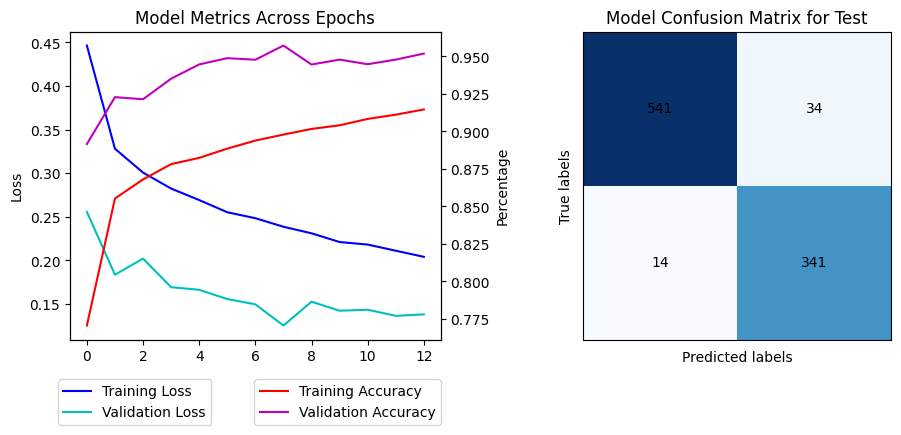

In [12]:
Trainer.fit(trainLoader, validationLoader, config.EPOCHS)
Trainer.Test_Model(testLoader)

print("\nTest Accuracy:", Trainer.Metrics["Test Accuracy"])

Trainer.Graph_Metrics()

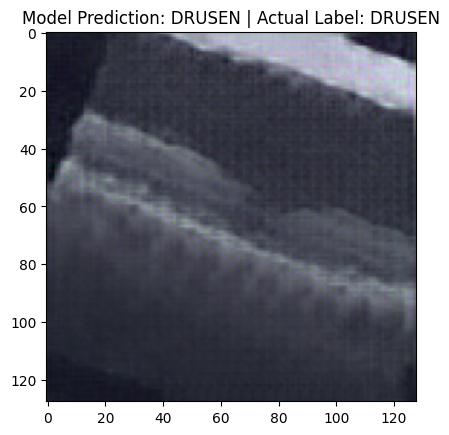

In [25]:
img, label = train[5]

# Make a prediction based on test data
with torch.no_grad():
    pred = Trainer.model(img.reshape(1,3,128,128).to(config.device)) # Replicate a batch with single image
    pred_cls = torch.argmax(pred).item()

img = torch.permute(img, (1,2,0))
img = (img-torch.min(img)) / (torch.max(img)-torch.min(img))

# View some of the testing data and model predictions
plt.imshow(img)
_=plt.title(f"Model Prediction: {definitions[pred_cls]} | Actual Label: {definitions[label]}")

In [26]:
torch.save(Trainer.model.state_dict(), 'models/BC_B.pth')